In [1]:
from imports import *

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

In [16]:
scoring = {'AUC': 'roc_auc',
           'Precision': make_scorer(precision_score, pos_label=1), 
           'Recall': make_scorer(recall_score, pos_label=-1),
           'F1': make_scorer(f1_score, average='weighted')}

In [17]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%} / {len(dfsf)}")

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

SF anomaly rate is 4.5% / 73237


In [18]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=1)
gs_svm_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(0.045, 0.09, 0.005), 'kernel': ["rbf"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

Time for SVM fitting: 236.478


In [19]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=2)
gs_svm_2 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(0.045, 0.09, 0.005), 'kernel': ["rbf"], 'gamma': ["auto"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_2.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_2 = gs_svm_2.cv_results_

Time for SVM fitting: 235.435


In [20]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=3)
gs_svm_3 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(0.045, 0.09, 0.005), 'kernel': ["poly"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_3.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_3 = gs_svm_3.cv_results_

Time for SVM fitting: 151.878


<ipython-input-29-7ffd6abdfc23>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


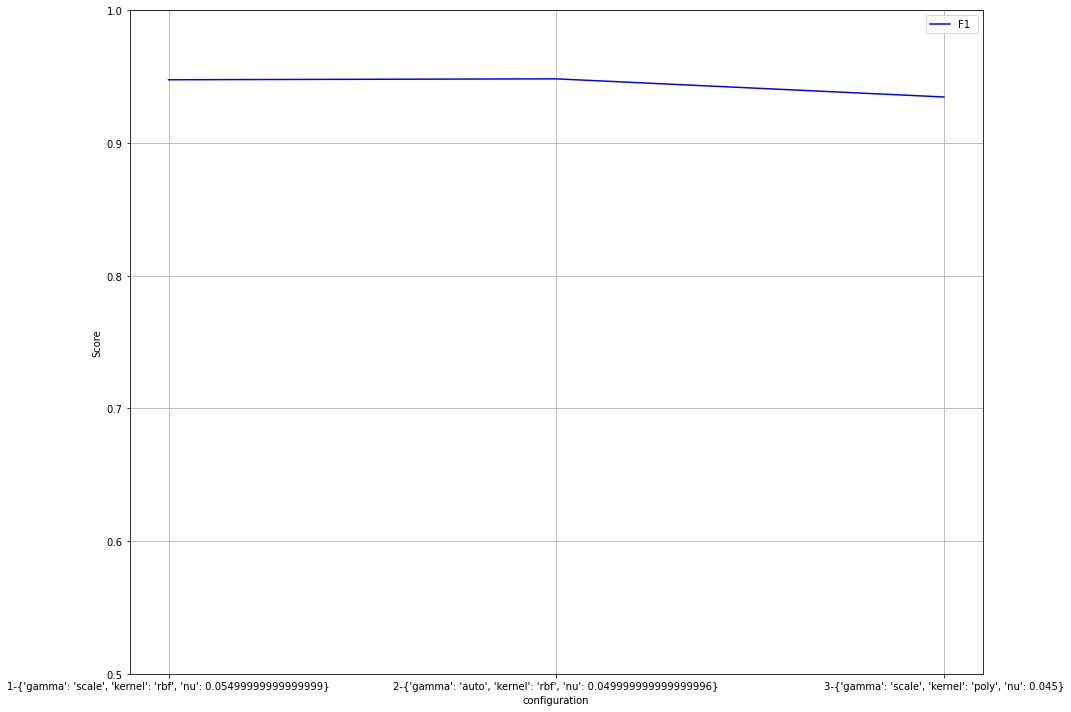

In [29]:
plt.figure(figsize=(15,10))

plt.xlabel("configuration")
plt.ylabel("Score")

ax = plt.axes()
ax.set_ylim(0.500, 1.000)
pad = 0.005

colors = {'lof': 'r', 'if':'b', 'dbscan':'c', 'svm':'y'}
scorer = 'F1'

best_index = np.nonzero(results_svm_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_svm_1['mean_test_%s' % scorer][best_index]
best_param_1 = results_svm_1['params'][best_index]

best_index = np.nonzero(results_svm_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_svm_2['mean_test_%s' % scorer][best_index]
best_param_2 = results_svm_2['params'][best_index]

best_index = np.nonzero(results_svm_3['rank_test_%s' % scorer] == 1)[0][0]
best_score_3 = results_svm_3['mean_test_%s' % scorer][best_index]
best_param_3 = results_svm_3['params'][best_index]

# best_index = np.nonzero(results_svm_sf_4['rank_test_%s' % scorer] == 1)[0][0]
# best_score_4 = results_svm_sf_4['mean_test_%s' % scorer][best_index]
# best_param_4 = results_svm_sf_4['params'][best_index]

Y_axis = np.array([best_score_1, best_score_2, best_score_3])
X_axis = np.array([f"1-{best_param_1}", f"2-{best_param_2}", f"3-{best_param_3}"])

ax.plot(X_axis, Y_axis, '-', color=colors['if'],label="%s " % (scorer))
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("svm_figure.png", dpi=100)

plt.show()

# Comparison

In [34]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=1)
param = best_param_1
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = OneClassSVM(kernel=param['kernel'], gamma=param['gamma'], nu=param['nu']).fit(x_train_sf).predict(x_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = OneClassSVM().fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.05499999999999999}
Time for SVM fitting: 17.972
---0.9537729630584931
---0.6876170499662896


In [35]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=2)
param = best_param_2
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = OneClassSVM(kernel=param['kernel'], gamma=param['gamma'], nu=param['nu']).fit(x_train_sf).predict(x_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = OneClassSVM().fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.049999999999999996}
Time for SVM fitting: 17.934
---0.9614221309136562
---0.6882430151884492


In [37]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=3)
param = best_param_3
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = OneClassSVM(kernel=param['kernel'], gamma=param['gamma'], nu=param['nu']).fit(x_train_sf).predict(x_test_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = OneClassSVM().fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'gamma': 'scale', 'kernel': 'poly', 'nu': 0.045}
Time for SVM fitting: 10.396
---0.9649308637027283
---0.6826031219365056


# Archive

In [38]:
results_svm_1

{'mean_fit_time': array([4.6306502 , 5.11502067, 5.20066182, 6.09889436, 6.590343  ,
        7.07237093, 7.92040881, 8.02568126, 8.48540958]),
 'std_fit_time': array([0.12191405, 0.22227681, 0.1870071 , 0.0489273 , 0.37039363,
        0.08951269, 0.18168845, 0.25793864, 0.13073613]),
 'mean_score_time': array([1.18210196, 1.27119819, 1.39359395, 1.61965378, 1.68481922,
        1.7856245 , 2.04110018, 2.14700691, 2.24029295]),
 'std_score_time': array([0.026891  , 0.0758545 , 0.06915264, 0.08317724, 0.09403544,
        0.06901534, 0.16078243, 0.02095035, 0.08943702]),
 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale', 'scale', 'scale',
                    'scale', 'scale', 'scale'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf'],
             

In [39]:
results_svm_2

{'mean_fit_time': array([4.59648132, 5.10838811, 5.67701538, 5.86032565, 6.59282756,
        6.96126294, 7.53370476, 8.07009157, 8.47928754]),
 'std_fit_time': array([0.10980449, 0.2139683 , 0.35016906, 0.29160383, 0.1102881 ,
        0.16288381, 0.11754453, 0.27698292, 0.16672213]),
 'mean_score_time': array([1.31376219, 1.46560884, 1.4736646 , 1.62724376, 1.6411465 ,
        1.69198505, 1.80740054, 2.07927044, 2.43644476]),
 'std_score_time': array([0.16308041, 0.09698267, 0.04602325, 0.24108478, 0.10895652,
        0.04540636, 0.09736413, 0.13887866, 0.23257621]),
 'param_gamma': masked_array(data=['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto',
                    'auto', 'auto'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf'],
              mask=[Fa

In [40]:
results_svm_3

{'mean_fit_time': array([2.84116864, 3.43034482, 3.33127761, 4.02551603, 4.21886738,
        4.59731992, 4.5762527 , 5.40818008, 6.09977253]),
 'std_fit_time': array([0.08761936, 0.01190946, 0.24330537, 0.05426051, 0.30080873,
        0.15267119, 0.07230954, 0.26394836, 0.06843346]),
 'mean_score_time': array([0.79572002, 0.90075803, 0.88710984, 1.06110128, 1.08314888,
        1.18822233, 1.19186632, 1.30830622, 1.42885693]),
 'std_score_time': array([0.07283431, 0.01779197, 0.01052747, 0.0812991 , 0.03019581,
        0.0330685 , 0.0280622 , 0.05398656, 0.02785504]),
 'param_gamma': masked_array(data=['scale', 'scale', 'scale', 'scale', 'scale', 'scale',
                    'scale', 'scale', 'scale'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['poly', 'poly', 'poly', 'poly', 'poly', 'poly', 'poly',
                    'poly', 'poly'],
    

# Manual parameter tuning

In [3]:
def cross_validation_svm(contamination, kernel, gamma, random_state, silent=True):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = OneClassSVM(kernel = kernel, gamma = gamma, nu = c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred))
        f = f1_score(y_test, y_pred, average = 'weighted')
        fm = f1_score(y_test, y_pred, average = 'macro')
        p = precision_score(y_test, y_pred, pos_label = -1)
        r = recall_score(y_test, y_pred, average = 'macro')
        a = roc_auc_score(y_test, y_pred)
        if f > highest_score: highest_score = f; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f},{fm}")
            print("--------------------")
    return (highest_score_c, y_pred, f, len(positives) - tp, tp, p, r, t)

In [4]:
target = "target"
sf = datasets.fetch_kddcup99(subset='SF', percent10=True)
dfSF=pd.DataFrame(sf.data, 
                  columns=["duration", "service", "src_bytes", "dst_bytes"])
assert len(dfSF)>0, "SF dataset no loaded."

dfSF[target]=sf.target
anomaly_rateSF = 1.0 - len(dfSF.loc[dfSF[target]==b'normal.'])/len(dfSF)

print("SF Anomaly Rate is:"+"{:.1%}".format(anomaly_rateSF))

dfSF['binary_target'] = [1 if x==b'normal.' else -1 for x in dfSF[target]]

toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfSF[f] = list(map(byte_decoder, dfSF[f]))
    dfSF[f] = leSF.fit_transform(dfSF[f])

Y_axis_f1 = []
Y_axis_recall = []
best_param = []

rs = 1
x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(0.05, 0.4, 0.02)
kernel = "rbf"
gamma = "scale"

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_svm(contaminations, kernel, gamma, rs, silent=False)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append((rs, cmax, kernel, gamma))

rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(0.05, 0.4, 0.02)
kernel = "rbf"
gamma = "auto"

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_svm(contaminations, kernel, gamma, rs, silent=True)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append((rs, cmax, kernel, gamma))

rs = 3
x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(0.05, 0.4, 0.02)
kernel = "poly"
gamma = "scale"

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_svm(contaminations, kernel, gamma, rs, silent=True)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append((rs, cmax, kernel, gamma))

rs = 4
x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(0.05, 0.4, 0.02)
kernel = "linear"
gamma = "scale"

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation_svm(contaminations, kernel, gamma, rs, silent=True)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append((rs, cmax, kernel, gamma))

SF Anomaly Rate is:4.5%
Finished trainning in 0:00:07.753031 seconds
contamination: 0.05 	 tp: 582/support: 791/predicted: 1364 -> fp = 782
AUC : 84.6% 	 precision: 0.427 	 recall: 0.846 	 f1: 0.9526221818654705,0.7556927014628311
--------------------
Finished trainning in 0:00:10.540735 seconds
contamination: 0.07 	 tp: 588/support: 791/predicted: 1666 -> fp = 1078
AUC : 84.1% 	 precision: 0.353 	 recall: 0.841 	 f1: 0.9415998624413807,0.7205678858344022
--------------------
Finished trainning in 0:00:13.542892 seconds
contamination: 0.09000000000000001 	 tp: 200/support: 791/predicted: 1496 -> fp = 1296
AUC : 58.9% 	 precision: 0.134 	 recall: 0.589 	 f1: 0.9117680601275109,0.5599699595913482
--------------------
Finished trainning in 0:00:16.560885 seconds
contamination: 0.11000000000000001 	 tp: 727/support: 791/predicted: 2226 -> fp = 1499
AUC : 91.7% 	 precision: 0.327 	 recall: 0.917 	 f1: 0.9331151039964567,0.7177109967897002
--------------------
Finished trainning in 0:00:19.3

<ipython-input-13-176837a52d89>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


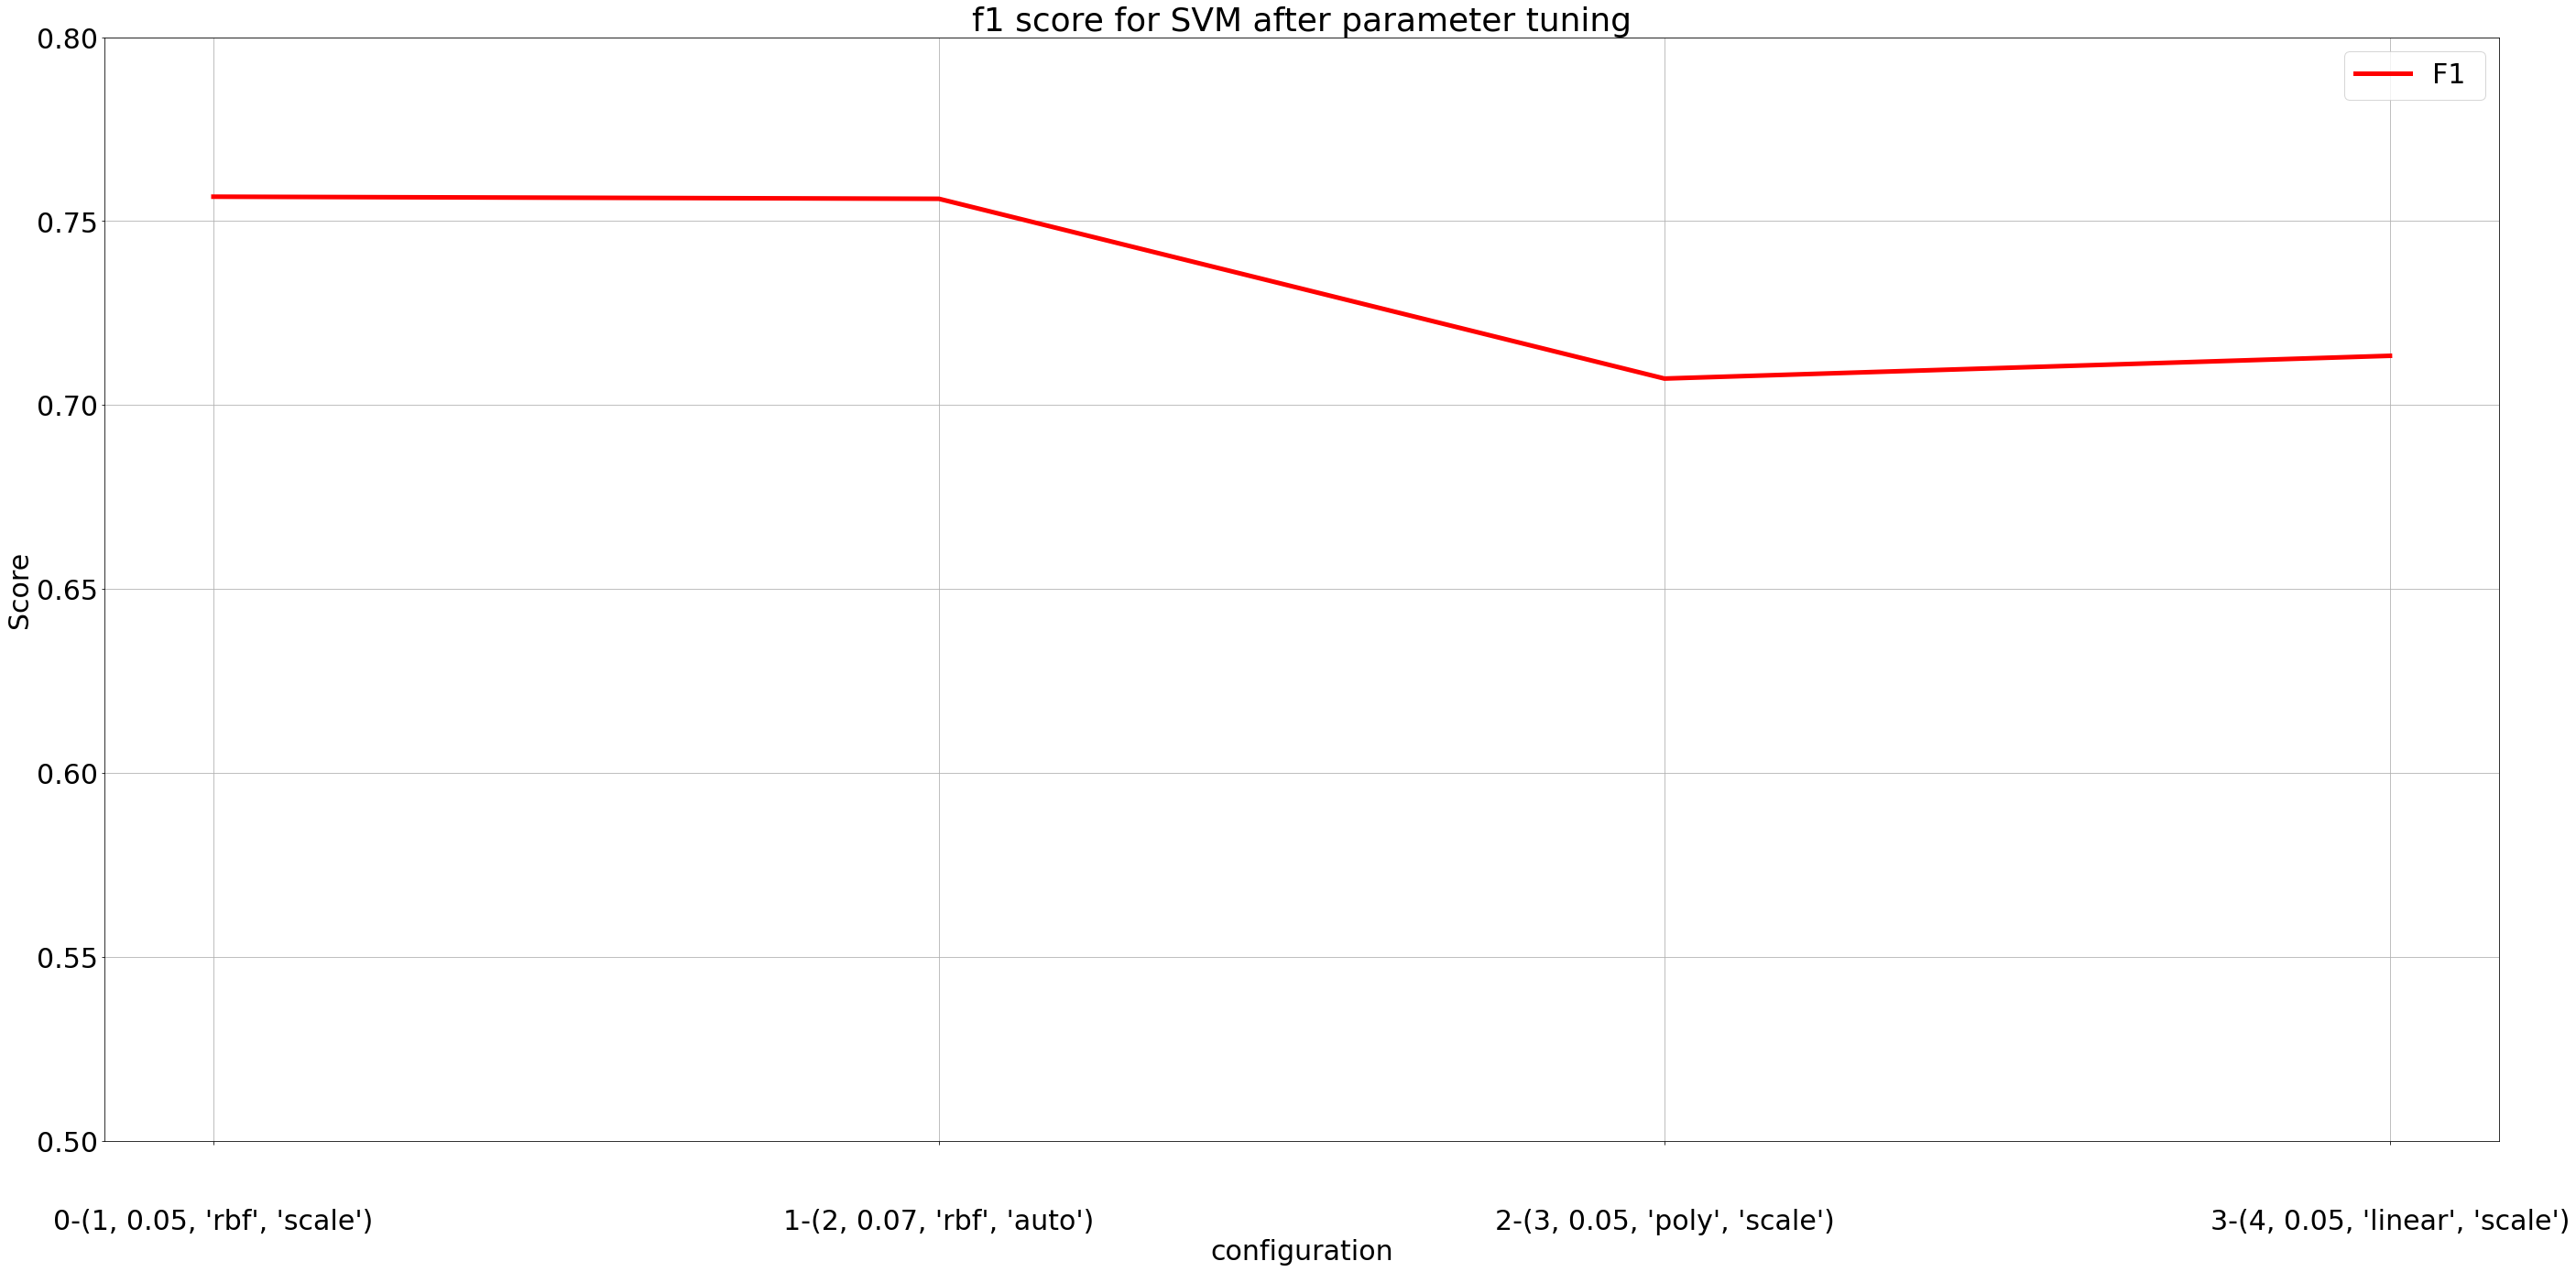

In [13]:
plt.figure(figsize=(40,20))
plt.rc('font', size=30)
plt.title('f1 score for SVM after parameter tuning')
plt.xlabel("configuration")
plt.ylabel("Score")
ax = plt.axes()
ax.set_ylim(0.5, 0.8)
pad = 0.005

labels = [f"\n\n{rs}-{cmax}" for rs, cmax in enumerate(best_param)]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'F1'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis_f1, '-', color=colors['1'],label="%s " % ("F1"), linewidth=5)
# ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("10 percent SVM_graph_SF.png", dpi=100)

plt.show()

# Comparison against default values

In [ ]:
f1_tuned = []
auc_tuned = []
r_tuned = []
f1_not_tuned = []
r_not_tuned = []
auc_not_tuned = []


for rs, c, k, g in best_param:
    print(f"---{[rs, c, k, g]}")
    x_train, x_test, y_train, y_test = train_test_split(dfSF.drop(["target", "binary_target"], axis=1), dfSF['binary_target'], test_size=0.25, random_state=rs)

    stime = time.time()
    y_pred = OneClassSVM(kernel = kernel, gamma = gamma, nu = c).fit(x_train).predict(x_test)
    print("Time for SVM fitting: %.3f" % (time.time() - stime))
    f = f1_score(y_test, y_pred, pos_label=-1)
    print(f"---{f}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)
    y_pred = OneClassSVM().fit(x_train).predict(x_test)
    f = f1_score(y_test, y_pred, pos_label=-1)
    print(f"---{f}")
    f1_not_tuned.append(f)
    r_not_tuned.append(recall_score(y_test, y_pred, average = 'macro'))
    auc_not_tuned.append(roc_auc_score(y_test, y_pred))
    
    
fig, ax = plt.subplots(figsize = (30,20))
plt.rc('font', size=30)

width = 1
labels = [f"{rs}-c: {c:.2}\n kernel: {k}\n gamma: {g}" for rs, c, k, g in best_param]
ax.set_xticks([i*5 + width/2 for i in range(len(f1_tuned))])
ax.set_xticklabels(labels)
ax.set_ylabel('f1-score')

ax.set_title('f1 score before and after parameter tuning using cross validation search')

ax.bar([i*5 for i in range(len(f1_tuned))], f1_tuned, width=width)
ax.bar([i*5 + width for i in range(len(f1_not_tuned))], f1_not_tuned, width=width)
fig.tight_layout()
ax.legend(['f1 score tuned', 'f1 score not tuned'])
plt.show()